In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import argparse
import numpy as np
from models import create_model
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from ptoa.tsetranslate.model import UBlock, ULayer
from ptoa.data.knee import KneeDataset, Knee
from data.knee_dataset import PixSliceTranslateDataset
import matplotlib.pyplot as plt
import tqdm

In [41]:
kds = KneeDataset(load=True)

outliers = [
    'patient-ccf-51566-20211014-knee_contra', # min=-2 (looks pretty normal)
    'patient-ccf-001-20210917-knee', # max=1+ (looks pretty normal)
]
kds.knees = [k for k in kds.knees if k.base not in outliers]
kds.zscore()
ds = PixSliceTranslateDataset(kds, slc_has_bmel=False)

100%|██████████| 191/191 [00:19<00:00,  9.99it/s]


ValueError: Sum of input lengths does not equal the length of the input dataset!

In [3]:
def scale(img, min_q=0., max_q=1., new_min=None, new_max=None):
    min_val = np.quantile(img, min_q)
    max_val = np.quantile(img, max_q)
    if new_min is None:
        new_min = min_val
    if new_max is None:
        new_max = max_val
    img = np.clip(img, min_val, max_val)
    img = img / (max_val - min_val) * (new_max - new_min)
    img = img - img.min() + new_min
    return img

In [4]:
def subplots(cols=1, figsize=7.5):
    fig, ax = plt.subplots(1, cols, figsize=(cols * figsize, figsize))
    return fig, ax

In [5]:
def plots(imgs, cp=None, title=None, axtitles=None, cbar=True, figsize=7.5, reorient=True):
    if not isinstance(imgs, (list, tuple)):
        imgs = [imgs]
    n_axes = len(imgs)
    if axtitles is None:
        axtitles = [None] * n_axes
    elif not isinstance(axtitles, (list, tuple)):
        axtitles = [axtitles]

    fig, ax = subplots(n_axes, figsize)
    if n_axes == 1:
        ax = [ax]
    fig.suptitle(title)
    fig.tight_layout()
    if cp is not None and reorient:
        cp = cp[1], cp[0]
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
        if reorient:
            img = np.fliplr(np.rot90(img, k=3))
        mat = ax[i].matshow(img, cmap='gray')
        if cp is not None:
            ax[i].scatter(cp[0], cp[1], s=2_000, edgecolors='r', alpha=0.5, facecolors='none', linewidths=1.25)
        ax[i].set_title(axtitles[i])
        if cbar is not None:
            plt.colorbar(mat, ax=ax[i])
    return fig, ax

## train / load pretrained model

In [6]:
opt = argparse.Namespace(
  name='DESS2TSE_myublock_dropout',
  epoch='latest',
  no_dropout=False,
  netG='myublock',
  isTrain=False,
  batch_size=1,
  dataroot='NULL',
  use_wandb=False,
  gpu_ids=[0],
  checkpoints_dir='./checkpoints',
  model='pix2pix',
  input_nc=1,
  output_nc=1,
  ngf=64,
  ndf=64,
  netD='basic',
  n_layers_D=3,
  norm='batch',
  init_type='normal',
  init_gain=0.02,
  dataset_mode='aligned',
  direction='AtoB',
  serial_batches=False,
  num_threads=4,
  load_size=256,
  crop_size=256,
  max_dataset_size=np.inf,
  preprocess='resize_and_crop',
  no_flip=False,
  display_winsize=256,
  load_iter=0,
  verbose=False,
  suffix='',
  display_freq=400,
  display_ncols=4,
  display_id=1,
  display_server='http://localhost',
  display_env='main',
  display_port=8097,
  update_html_freq=1000,
  print_freq=100,
  no_html=False,
  save_latest_freq=5000,
  save_epoch_freq=5,
  save_by_iter=False,
  continue_train=False,
  epoch_count=1,
  phase='train',
  n_epochs=300,
  n_epochs_decay=300,
  beta1=0.5,
  lr=0.0002,
  gan_mode='vanilla',
  pool_size=0,
  lr_policy='linear',
  lr_decay_iters=50,
  no_boneseg=False,
  lambda_L1=10.0,
)

In [7]:
model = create_model(opt)
model.setup(opt)
model.eval()

initialize network with normal
model [Pix2PixModel] was created
loading the model from ./checkpoints/DESS2TSE_myublock_dropout/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.408 M
-----------------------------------------------


# Get Mean Embeddings >:]

In [8]:
kds_nobmel = KneeDataset()
outliers = [
    'patient-ccf-51566-20211014-knee_contra', # min=-2 (looks pretty normal)
    'patient-ccf-001-20210917-knee', # max=1+ (looks pretty normal)
]
kds_nobmel.knees = [k for k in kds_nobmel.knees if k.base not in outliers]
kds_nobmel.zscore()
ds_nobmel = PixSliceTranslateDataset(kds_nobmel, slc_has_bmel=False)
dl_nobmel = DataLoader(ds_nobmel)

100%|██████████| 191/191 [00:18<00:00, 10.46it/s]


In [9]:
# collect embeddings
# model.get_embeddings()

In [10]:
for i, batch in enumerate(tqdm.tqdm(dl_nobmel)):
    model.set_input(batch)
    model.forward()

100%|██████████| 4508/4508 [01:54<00:00, 39.44it/s]


In [11]:
for batch in dl_nobmel:
    break

In [12]:
f'embeddings (output of encoder): n={len(model.embeddings)}; shape={model.embeddings[0].shape}'

'embeddings (output of encoder): n=4508; shape=torch.Size([512])'

In [13]:
kds_bmel = KneeDataset(has_bmel=True)
outliers = [
    'patient-ccf-51566-20211014-knee_contra', # min=-2 (looks pretty normal)
    'patient-ccf-001-20210917-knee', # max=1+ (looks pretty normal)
]
kds_bmel.knees = [k for k in kds_bmel.knees if k.base not in outliers]
kds_bmel.zscore()
ds_bmel = PixSliceTranslateDataset(kds_bmel, slc_has_bmel=True)
dl_bmel = DataLoader(ds_bmel, shuffle=True)

100%|██████████| 63/63 [00:08<00:00,  7.29it/s]


## `model_avg` uses avg embeddings

In [14]:
model_avg = create_model(opt)
model_avg.setup(opt)
model_avg.eval()

initialize network with normal
model [Pix2PixModel] was created
loading the model from ./checkpoints/DESS2TSE_myublock_dropout/latest_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 54.408 M
-----------------------------------------------


In [15]:
if isinstance(model.hook_handle, torch.utils.hooks.RemovableHandle):
    model.hook_handle.remove()
model.hook_handle = model.set_embeddings(embeddings=model.embeddings)

## (`model` uses sample embeddings)

In [16]:
model.hook_handle.remove() # no need to collect embeddings anymore
model.eval()

# Pick sample slice

In [17]:
dess_thresh = 0.98

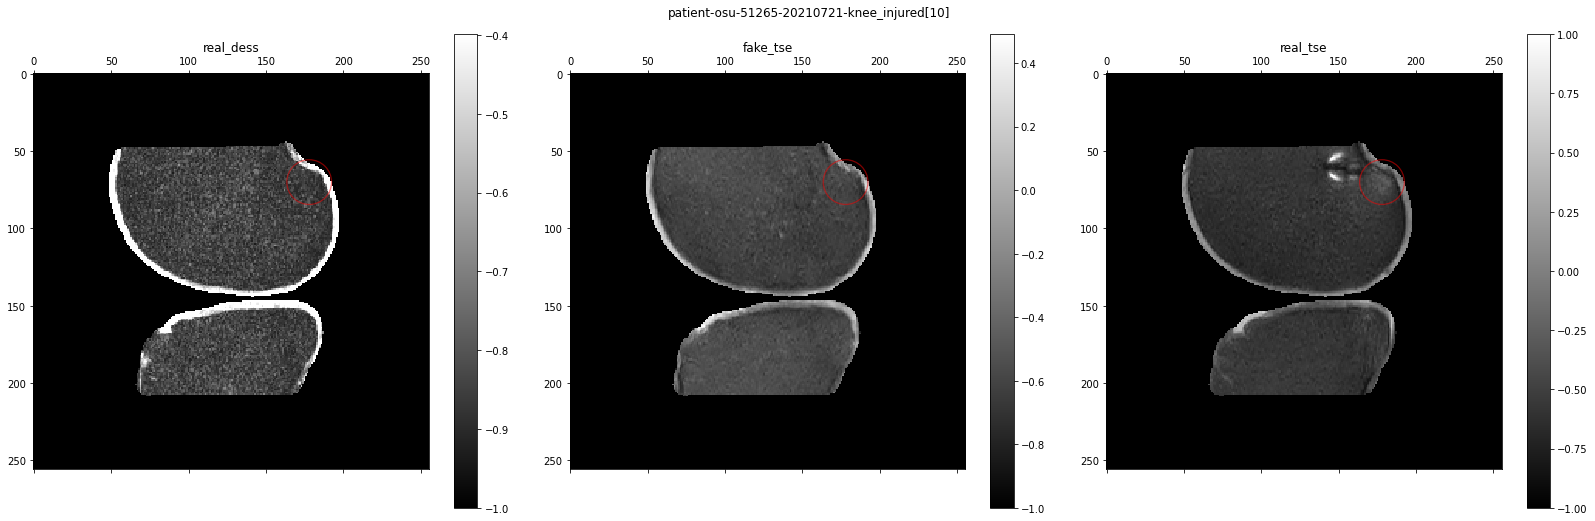

In [19]:
# choose a good bmel slice
for batch in dl_bmel:
    if batch['id'][0] == 'patient-osu-51265-20210721-knee_injured[10]':
        model.set_input(batch)
        model_avg.set_input(batch)
        model.forward()
        model_avg.forward()
        break

real_dess = model.real_A[0, 0].detach().cpu()
fake_tse = model.fake_B[0,0].detach().cpu()
fake_tse_avg = model_avg.fake_B[0, 0].detach().cpu()
real_tse = model.real_B[0, 0].detach().cpu()
real_dess = scale(real_dess, max_q=dess_thresh)

fig, ax = plots([real_dess, fake_tse, real_tse], axtitles=['real_dess', 'fake_tse', 'real_tse'], cp=model.image_cp, title=model.image_id[0])
plt.show()

# Epistemic Uncertainty (variance from normal)

In [20]:
epistemic_thresh = .9

In [21]:
epistemic = real_tse - fake_tse_avg
epistemic = scale(epistemic, min_q=epistemic_thresh, new_min=0, new_max=1)

# Aleatoric Uncertainty (variance within normal): using `model_avg`

## Control (MCDropout off)

In [22]:
n_montecarlo = 100
aleatoric_thresh = 1 - 1e-4
aleatoric_offset = 0.1

In [23]:
for m in model_avg.netG.modules():
    if m.__class__.__name__.startswith('Dropout'):
        m.eval()

100%|██████████| 100/100 [00:01<00:00, 52.33it/s]


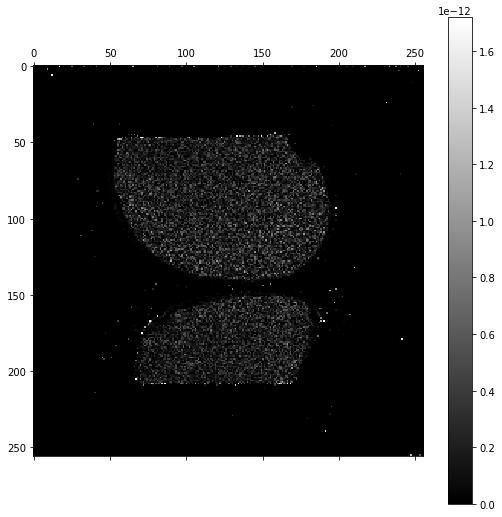

In [24]:
# model or model_avg?
fakes = []
for i in tqdm.tqdm(range(n_montecarlo)):
    model_avg.forward()
    fake_B = model_avg.fake_B[0, 0]
    fakes.append(fake_B.detach().cpu())
fakes = np.stack(fakes, axis=0)
_ = plots([np.var(fakes, axis=0)])

## MCDropout on

In [25]:
for m in model_avg.netG.modules():
    if m.__class__.__name__.startswith('Dropout'):
        m.train()

In [26]:
fakes = []
for i in tqdm.tqdm(range(n_montecarlo)):
    model_avg.forward()
    fake_B = model_avg.fake_B[0,0]
    fakes.append(fake_B.detach().cpu())
fakes = np.stack(fakes, axis=0)
aleatoric = np.var(fakes, axis=0)
aleatoric = scale(aleatoric, max_q=aleatoric_thresh, new_min=0. + aleatoric_offset, new_max=1. + aleatoric_offset)

100%|██████████| 100/100 [00:02<00:00, 46.77it/s]


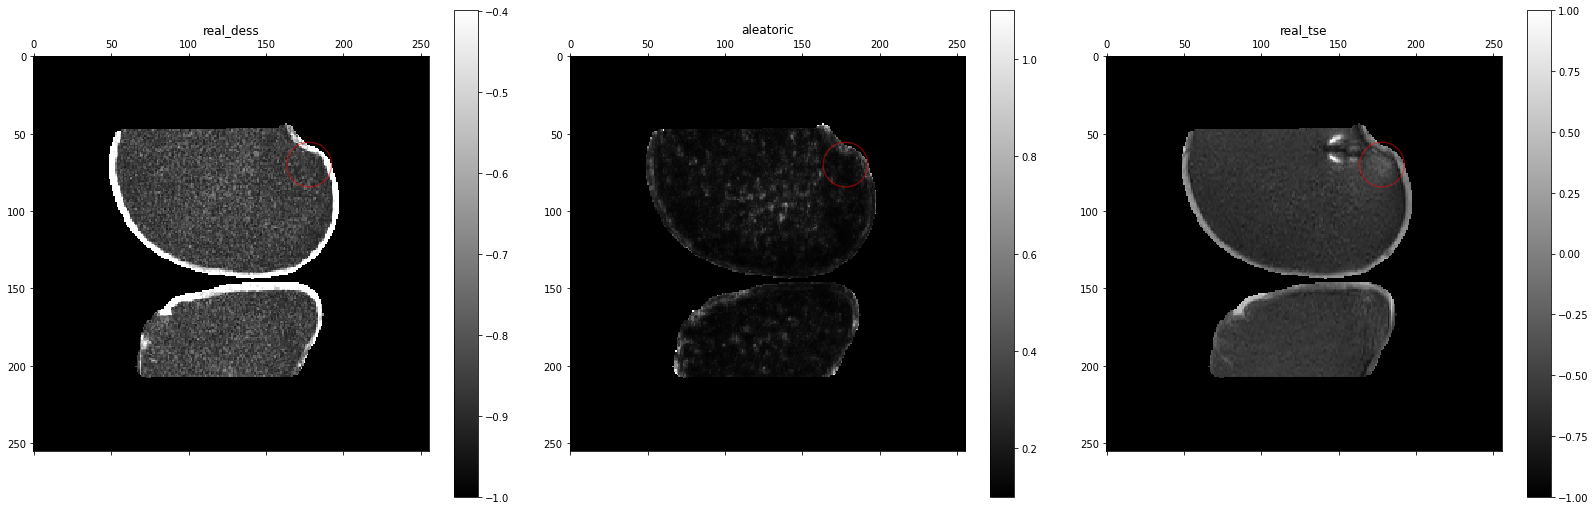

In [27]:
fig, ax = plots([real_dess, aleatoric, real_tse], axtitles=['real_dess', 'aleatoric', 'real_tse'], cp=model.image_cp,)
plt.show()

# Scibilic Uncertainty

In [28]:
scibilic = scale(epistemic / aleatoric, new_min=0, new_max=1)

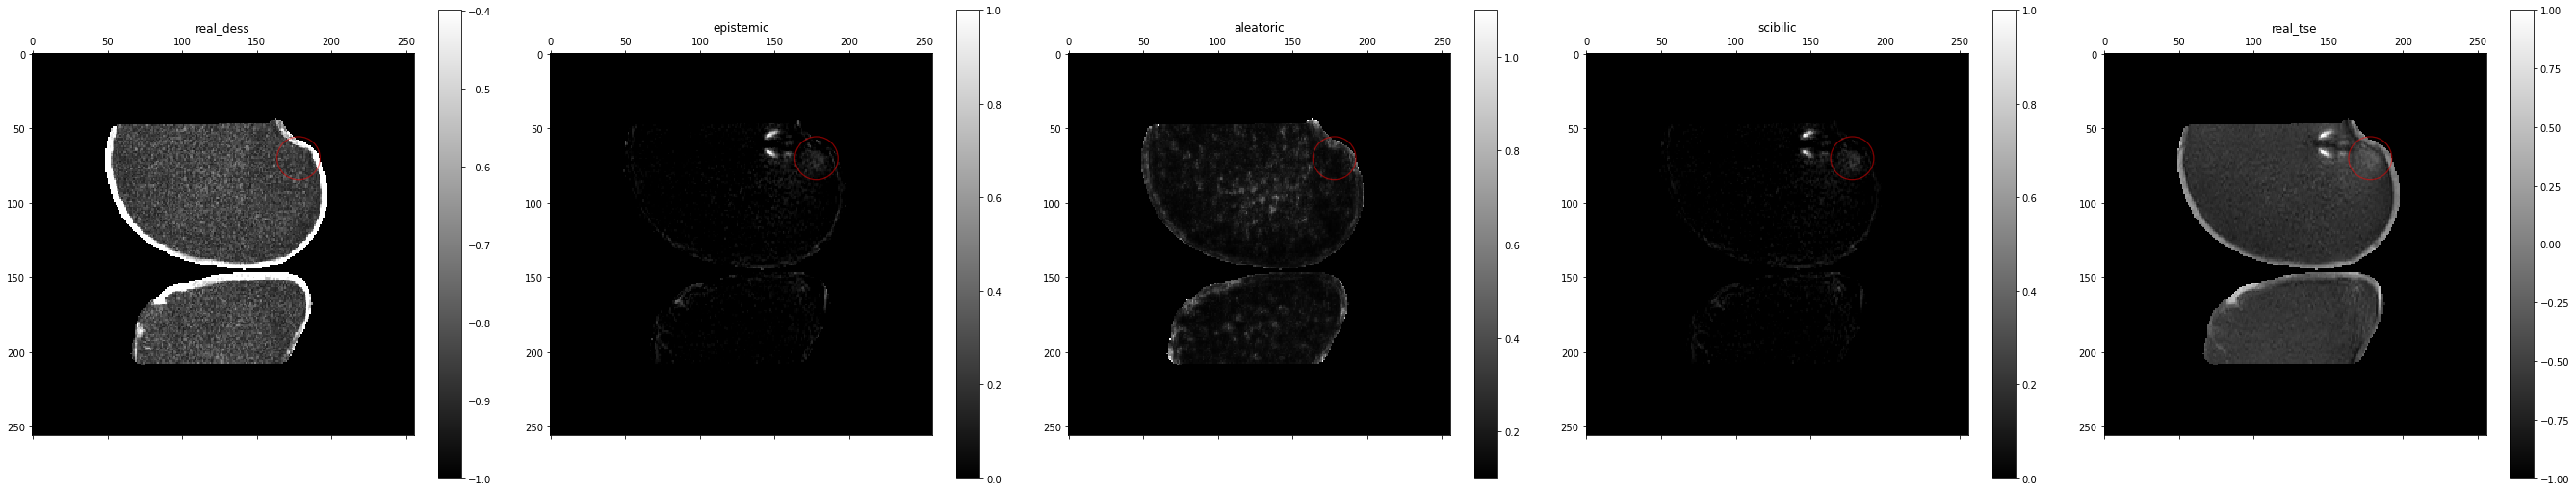

In [29]:
fig, ax = plots([real_dess, epistemic, aleatoric, scibilic, real_tse], axtitles=['real_dess', 'epistemic', 'aleatoric', 'scibilic', 'real_tse'], cp=model.image_cp,)
plt.show()

# Undo Bone Dilation
Cartilage mask not necessary (except erosion on the shafts; could use original bone masks instead)

In [32]:
model.set_input_eroded(batch)
eroded_mask = model.image_mask[0,0].detach().cpu()
eroded_scibilic = scibilic.clone()
eroded_scibilic[~eroded_mask] = 0

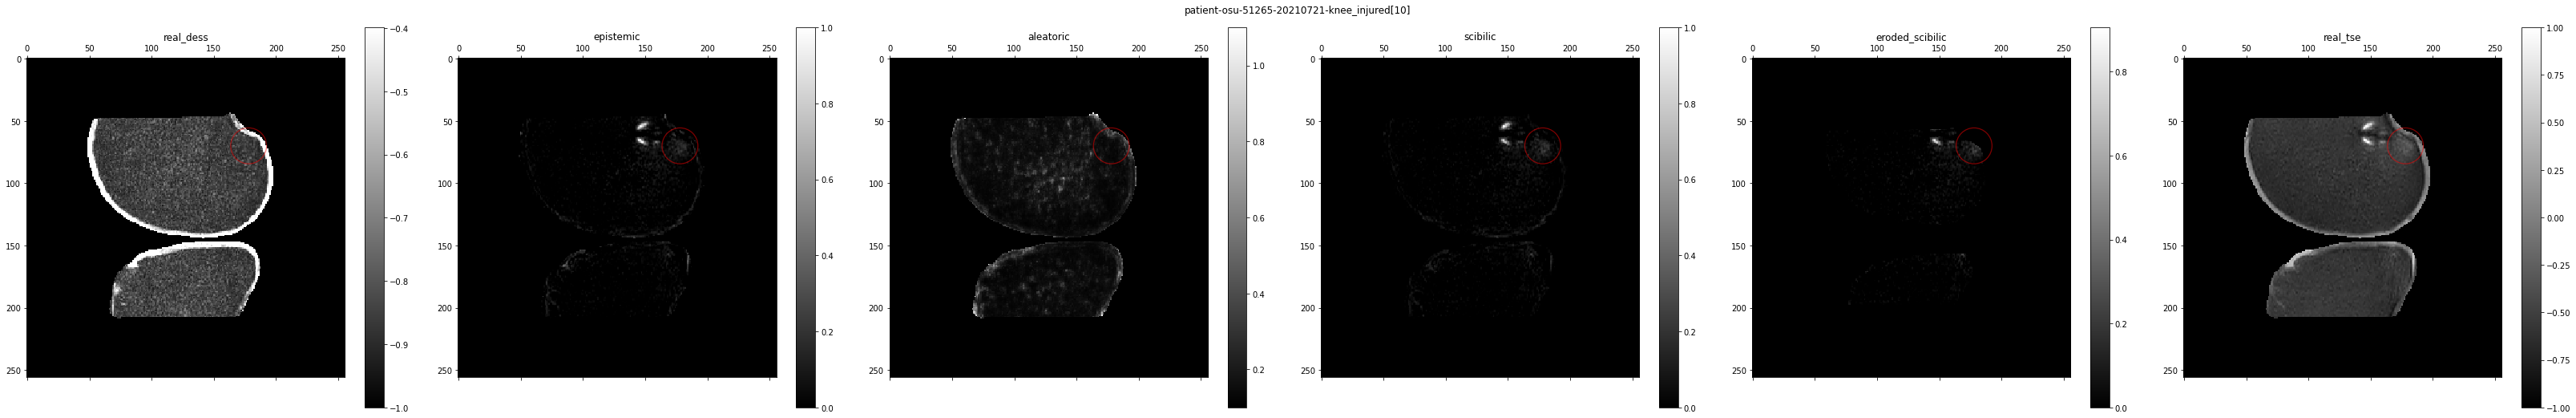

In [33]:
fig, ax = plots([real_dess, epistemic, aleatoric, scibilic, eroded_scibilic, real_tse], title=model.image_id[0], axtitles=['real_dess', 'epistemic', 'aleatoric', 'scibilic', 'eroded_scibilic', 'real_tse'], cp=model.image_cp,)
plt.show()

# Binarized Prediction

In [34]:
# import skimage.morphology as morph
# plt.matshow(morph.opening(eroded_scibilic, footprint=morph.disk(2)), cmap='gray')
# scibilic_thresh = .2
# binary_scibilic = scibilic > scibilic_thresh
# fig, ax = plots(binary_scibilic)

# Compare to Labels

In [35]:
ds_all = PixSliceTranslateDataset(kds_nobmel, slc_has_bmel=None)
dl_all = DataLoader(ds_all)

# TODO
## Training
* augmentation (esp. intensity range gradient)
* regularization / early stopping

## Morpho
with dilation, connected components, smoothing on scibilic to make bmelseg mask
## Check Labels
DICE curves

# Draw to File

In [36]:
savedir = '/home/yua4/temp/pytorch-CycleGAN-and-pix2pix/results_mpl/'

dess_thresh = 0.98
epistemic_thresh = .9
n_montecarlo = 100
aleatoric_thresh = 1 - 1e-4
aleatoric_offset = 0.1

In [37]:
for batch_ndx, batch in enumerate(tqdm.tqdm(dl_all)):

    if batch['bmel'].sum() == 0:
        continue

    model.set_input(batch)
    model_avg.set_input(batch)
    model.forward()
    model_avg.forward()

    n_samples = model.real_A.shape[0]
    for sample_ndx in range(n_samples):
        
        real_dess = model.real_A[sample_ndx, 0].detach().cpu()
        fake_tse = model.fake_B[sample_ndx, 0].detach().cpu()
        fake_tse_avg = model_avg.fake_B[sample_ndx, 0].detach().cpu()
        real_tse = model.real_B[sample_ndx, 0].detach().cpu()
        real_dess = scale(real_dess, max_q=dess_thresh)
        bmel = model.image_bmel[sample_ndx, 0].detach().cpu()
        
        epistemic = real_tse - fake_tse_avg
        epistemic = scale(epistemic, min_q=epistemic_thresh, new_min=0, new_max=1)

        for m in model_avg.netG.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()

        fakes = []
        for i in range(n_montecarlo):
            model_avg.forward()
            fake_B = model_avg.fake_B[sample_ndx, 0]
            fakes.append(fake_B.detach().cpu())
        fakes = np.stack(fakes, axis=0)
        
        aleatoric = np.var(fakes, axis=0)
        aleatoric = scale(aleatoric, max_q=aleatoric_thresh, new_min=0. + aleatoric_offset, new_max=1. + aleatoric_offset)

        for m in model_avg.netG.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.eval()

        scibilic = scale(epistemic / aleatoric, new_min=0, new_max=1)

        model.set_input_eroded(batch)
        eroded_mask = model.image_mask[sample_ndx, 0].detach().cpu()
        eroded_scibilic = scibilic.clone()
        eroded_scibilic[~eroded_mask] = 0

        fig, ax = plots([real_dess, epistemic, aleatoric, eroded_scibilic, bmel, real_tse], title=model.image_id[sample_ndx], axtitles=['real_dess', 'epistemic', 'aleatoric', 'scibilic', 'bmel_label', 'real_tse'], cp=model.image_cp,)

        plt.savefig(f'{savedir}{model.image_id[sample_ndx]}.png')
        # plt.show()
        plt.close()

100%|██████████| 4755/4755 [06:15<00:00, 12.66it/s] 


In [38]:
from PIL import Image
import glob
images = [Image.open(g) for g in glob.glob(savedir + '*.png')]
out = []
for img in tqdm.tqdm(images):
    img.load()
    bg = Image.new("RGB", img.size, (255, 255, 255))
    bg.paste(img, mask=img.split()[3]) # 3 is the alpha channel
    out.append(bg)
out[0].save(savedir + 'out.pdf', 'PDF', resolution=100.0, save_all=True, append_images=out[1:])

100%|██████████| 109/109 [00:05<00:00, 18.25it/s]


## ¯\\\_(ツ)\_/¯